In [2]:
import pandas as pd

# Load the dataset
file_path = '2020_bn_nb_data.txt'
data = pd.read_csv(file_path, delimiter='\t')  # Assuming the file is tab-separated

# Display the first few rows
print(data.head())

  EC100 EC160 IT101 IT161 MA101 PH100 PH160 HS101 QP
0    BC    CC    BB    BC    CC    BC    AA    BB  y
1    CC    BC    BB    BB    CC    BC    AB    BB  y
2    AB    BB    AB    AB    BB    CC    BC    AB  y
3    BC    CC    BB    BB    BB    BB    BC    BB  y
4    BC    AB    CD    BC    BC    BC    BC    CD  y


In [3]:
!pip install pgmpy

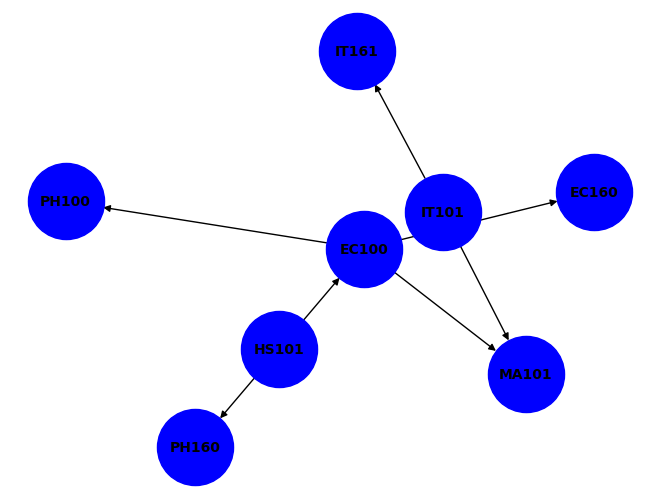

In [7]:
from pgmpy.models import BayesianNetwork
import matplotlib.pyplot as plt
import networkx as nx

model = BayesianNetwork([('EC100', 'EC160'), ('EC100', 'PH100'),
                         ('HS101', 'PH160'), ('IT101', 'MA101'),
                         ('IT101', 'IT161'), ('EC100', 'MA101'),
                         ('HS101', 'EC100')])

graph = nx.DiGraph(model.edges())

pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
plt.show()


In [9]:
from pgmpy.estimators import MaximumLikelihoodEstimator

model.fit(data, estimator=MaximumLikelihoodEstimator)

for node in model.nodes():
    cpd = model.get_cpds(node)
    print(f"CPT for {node}:")
    print(cpd)

CPT for EC100:
+-----------+----------------------+-----+----------------------+----------+
| HS101     | HS101(AA)            | ... | HS101(DD)            | HS101(F) |
+-----------+----------------------+-----+----------------------+----------+
| EC100(AA) | 0.047619047619047616 | ... | 0.0                  | 0.0      |
+-----------+----------------------+-----+----------------------+----------+
| EC100(AB) | 0.21428571428571427  | ... | 0.0                  | 0.0      |
+-----------+----------------------+-----+----------------------+----------+
| EC100(BB) | 0.21428571428571427  | ... | 0.034482758620689655 | 0.0      |
+-----------+----------------------+-----+----------------------+----------+
| EC100(BC) | 0.30952380952380953  | ... | 0.034482758620689655 | 0.0      |
+-----------+----------------------+-----+----------------------+----------+
| EC100(CC) | 0.11904761904761904  | ... | 0.034482758620689655 | 0.0      |
+-----------+----------------------+-----+-------------------

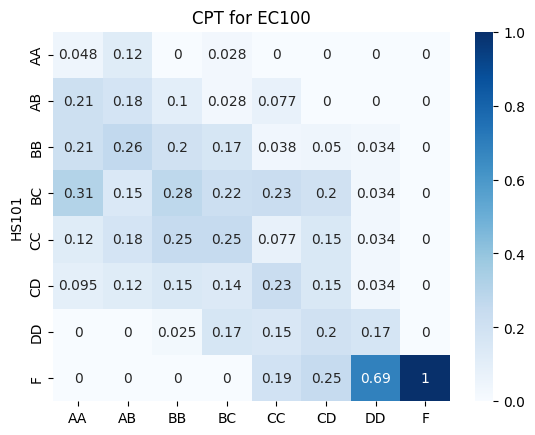

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_cpt(cpd):
    # Convert the CPD values into a DataFrame
    if len(cpd.variables) > 1:
        # Handling parents (conditional distributions)
        index = pd.MultiIndex.from_product([cpd.state_names[var] for var in cpd.variables[1:]], names=cpd.variables[1:])
        df = pd.DataFrame(cpd.values, index=index, columns=cpd.state_names[cpd.variable])
    else:
        # No parents (marginal distribution)
        df = pd.DataFrame(cpd.values, columns=cpd.state_names[cpd.variable])
    
    # Plotting the heatmap
    sns.heatmap(df, annot=True, cmap='Blues')
    plt.title(f"CPT for {cpd.variable}")
    plt.show()

# Example: plot CPT for 'EC100'
cpd_ec100 = model.get_cpds('EC100')
plot_cpt(cpd_ec100)


In [13]:
from pgmpy.inference import VariableElimination

# Initialize inference object
inference = VariableElimination(model)

# Query probability of a grade in PH100, given other course grades
result = inference.map_query(variables=['PH100'], evidence={'EC100': 'DD', 'IT101': 'CC', 'MA101': 'CD'})
print(result)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

{'PH100': 'CD'}


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score

# Extract feature columns and target column
features = data.drop(columns=['QP'])
target = data['QP']

# Convert categorical features to numerical codes
features = features.apply(lambda col: pd.Categorical(col).codes)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Build the Naive Bayes model
nb_model = CategoricalNB()
nb_model.fit(X_train, y_train)

# Test the model
y_pred = nb_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


Accuracy: 0.9714285714285714


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset (replace this with your actual data loading code)
# Assuming the last column is the target (QP) and the rest are features
data = pd.read_csv('2020_bn_nb_data.txt', sep='\t')  # Adjust as per your file

# Separate features and target
features = data.iloc[:, :-1]  # All columns except the last
target = data.iloc[:, -1]     # Last column (QP)


# Convert categorical features and target to numerical values using LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to all feature columns
for col in features.columns:
    features[col] = label_encoder.fit_transform(features[col])

# Also encode the target column
target = label_encoder.fit_transform(target)

# Initialize the Naive Bayes model
nb_model = GaussianNB()

# Perform 20 random train-test splits and calculate accuracy
accuracies = []
for i in range(20):
    # Split data (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=i)
    
    # Fit the model
    nb_model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = nb_model.predict(X_test)
    
    # Calculate accuracy and store it
    accuracies.append(accuracy_score(y_test, y_pred))

# Calculate and print the mean accuracy
print(f'Mean Accuracy: {sum(accuracies) / len(accuracies)}')


/tmp/ipykernel_11059/2074146462.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[col] = label_encoder.fit_transform(features[col])
/tmp/ipykernel_11059/2074146462.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[col] = label_encoder.fit_transform(features[col])
/tmp/ipykernel_11059/2074146462.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Mean Accuracy: 0.975
